<a href="https://colab.research.google.com/github/FutureDragon/Time-Series-Forecasting-Apple-Stock-Price-Using-SARIMA-Prophet/blob/master/Time_Series_Analysis_%26_Forecasting_of_Apple_Stock_Price_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Project Title : Apple Stock Price Forecasting Using SARIMA & Prophet**



**Problem Statement :-**

*Time Series Analysis of Apple Stock .*

**Problem Type** : Forecasting

**Actionable Decision** : Whether to Invest or Not in the Stock 

Importing and installing libraries


In [ ]:
#%%capture
##Installing
!pip install prophet
!pip install -U statsmodels
!pip install colorama

In [ ]:
##Importing Packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose as sd
from scipy import stats 
from statsmodels.graphics.gofplots import qqplot as qq
from scipy.stats import kurtosis
import scipy
from statsmodels.tsa.stattools import adfuller
from pylab import rcParams
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from pandas.core.window.rolling import Rolling
from sklearn.model_selection import train_test_split as split
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import statsmodels.api as sm
import warnings
import itertools
warnings.filterwarnings("ignore")
from statsmodels.stats.diagnostic import acorr_ljungbox
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, median_absolute_error, mean_squared_log_error
from sklearn.model_selection import KFold, ShuffleSplit, StratifiedKFold, StratifiedShuffleSplit, TimeSeriesSplit
from prophet import Prophet
from IPython import display
from matplotlib import pyplot
import os
import re
from colorama import Fore, Back, Style
import seaborn as sns
import plotly.express as px
import warnings
from matplotlib.patches import Patch

In [ ]:
##Matplotlib Parameters
import matplotlib.ticker as ticker
rcParams['axes.labelsize'] = 12
rcParams['xtick.labelsize'] = 12
rcParams['ytick.labelsize'] = 12
plt.style.context('fivethirtyeight')

# Loading Data 
From CSV File(Source: Yahoo Finance)

In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

In [ ]:
ticker = 'AAPL'

In [ ]:
#data = pd.read_csv('/content/drive/My Drive/GitHub Projects/Time Series /Orignal DataSet/AAPL.csv')
import yfinance as yf
ticker_data = yf.download(ticker, period='12y')

In [ ]:
data = ticker_data
data.head()

**Data Describtion :-**

**Date**  : Date of trading

**Open**  : Price at which security first trades

**High**  : Highest Price of the trading day

**Low**   : Lowest Price of the trading day

**Close** : Last Price the stock traded during the trading day

**Adj Close** : Price that is adjusts Coroporate Actions on Closing Price

**Volume** : Number of Shares that changed hands during the trading day

In [ ]:
##Summary Statistics
data.describe()

In [ ]:
##Exploring Data
data.info()

# Data Preprocessing

In [ ]:
##Dealing with Data Types

In [ ]:
##Converting Date to DateTime Object
#data['Date']

In [ ]:
#data['Date'] = pd.to_datetime(data['Date'],format='%Y-%m-%d')

In [ ]:
data.dtypes

In [ ]:
##Making Date as Index 
#data.set_index('Date',inplace=True)

In [ ]:
#data['Date'] = data.index

In [ ]:
data.head()

In [ ]:
##Checking Null Values
data.isnull().sum()

In [ ]:
##Visualizing 

In [ ]:
col_names = data.columns

fig = plt.figure(figsize=(24, 24))
for i in range(6):
  ax = fig.add_subplot(6,1,i+1)
  ax.plot(data.iloc[:,i],label=col_names[i])
  data.iloc[:,i].rolling(100).mean().plot(label='Rolling Mean')
  ax.set_title(col_names[i],fontsize=18)
  ax.set_xlabel('Date')
  ax.set_ylabel('Price')
  ax.patch.set_edgecolor('black')  
  plt.style.context('fivethirtyeight')
  plt.legend(prop={'size': 12})
  plt.style.use('fivethirtyeight')

fig.tight_layout(pad=3.0)

plt.show()

# **Feature Selection**
We can eliminate features like Open,Low, High Close automatically as they are high multicollinear with Adj Close .

We consider Adj Close as our target variables as it accounts for all corporate decisions like stock split and dividents.

In [ ]:
##HeatMap to Verify Multicollinearity between Features
fig = plt.figure(figsize=(16,12))
matrix = np.triu(data.corr())
ax = sns.heatmap(data.corr(),annot=True,annot_kws={"size":14},mask=matrix,cmap='coolwarm')
ax.tick_params(labelsize=14)
sns.set(font_scale=3)
ax.set_title('HeatMap')
plt.style.use('fivethirtyeight')
plt.show()

In [ ]:
##Data after feature selection
data_feature_selected = data.drop(axis=1,labels=['Open','High','Low','Close','Volume'])


In [ ]:
col_order = ['Date','Adj Close']
data_feature_selected = data_feature_selected.reindex(columns=col_order)
data_feature_selected

# Resampling

In [ ]:
##Resample Data to Monthly instead of Daily by Aggregating Using Mean
monthly_mean = data_feature_selected['Adj Close'].resample('M').mean()

In [ ]:
monthly_data = monthly_mean.to_frame()
monthly_data

In [ ]:
##Monthly Stock Price 
fig = plt.figure(figsize=(18,8))
plt.plot(monthly_data['Adj Close'],label='Monthly Averages Apple Stock')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
ax.set_title('Monthly Resampled Data')
plt.style.use('fivethirtyeight')
plt.legend(prop={'size': 12})
plt.show()

# Exploratory Data Analysis

In [ ]:
monthly_data['Year'] = monthly_data.index.year
monthly_data['Month'] = monthly_data.index.strftime('%B')
monthly_data['dayofweek'] = monthly_data.index.strftime('%A')
monthly_data['quarter'] = monthly_data.index.quarter
monthly_data

In [ ]:
##Checking Distribution of Our Data 
fig = plt.figure(figsize=(10,8))
sns.distplot(monthly_data['Adj Close']).set_title("Distribution Plot Adj Close -AAPL")
ax.tick_params(labelsize=12)
sns.set(font_scale=1)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)


**Distribution Plot Inference** : Distribution shows Right Skew

In [ ]:
fig = plt.figure(figsize=(8,6))
sns.boxplot(monthly_data['Adj Close']).set_title('Box Plot Apple Stock Price')
plt.style.context('fivethirtyeight')


**Box-Plot Inference** :- 

->Distribution shows Right Skew 

->Outlier towards the higher end around Stock price of 300$

In [ ]:
qq_plot = qq(monthly_data['Adj Close'],line='s')
plt.title('QQ Plot Apple Stock Price')

**QQ plot Inference :-**

->Heavy Tailed Distribution-Curve at Extremities

-> Shows extent of both right and left skews 

->Shows Distribution is Not following Gaussian Normal Distribution


In [ ]:
print('Skewness of Distribution is ',monthly_data['Adj Close'].skew())
print('Kurtosis of Distribution is ',monthly_data['Adj Close'].kurtosis())

Stock Price is Heavily skewed -Right tailed Skewness


In [ ]:
plt.figure(figsize=(12,12))
ax = sns.boxplot(x=monthly_data['Year'],y=monthly_data['Adj Close'],palette='RdBu')
ax.set_title('Box Plots Year Wise-Apple Stock Price')
plt.style.context('fivethirtyeight')

**Inferences Box Plot**

->Outliers Present in Year 2012 and 2019

->Lot of Variability in Years 2014, 2017-19

->2019 most volatile year among all years

->Upward Rising Trend is shown 

In [ ]:
group_by_yr = []
list_years = monthly_data['Year'].unique()
dict_IQR = {}
for yr in list_years:
  group_by_yr.append('df' + str(yr)) 

for enum,yr in enumerate(list_years):
   group_by_yr[enum] = monthly_data[str(yr)]['Adj Close']
   dict_IQR[str(yr)] = stats.iqr(group_by_yr[enum])

In [ ]:
##Interquartile Range(IQR) Year Wise for Stock Price
dict_IQR

In [ ]:

IQR_df = pd.DataFrame(dict_IQR.items(),columns=['Year','IQR'])
IQR_df.index = IQR_df['Year']
IQR_df.plot(kind='bar')
plt.xticks(rotation=45)
plt.style.context('fivethirtyeight')
plt.title('IQR Year Wise-Apple Stock Price')
plt.ylabel('InterQuartile Range')


->When Data is Not Normal Inter-Quartile Range(IQR)  is Better Variability Metric than Standard Deviation as IQR is not affected by outliers.

->As observed with BoxPlot 2014 and 2019 are the most volatile Years for Apple Stock

In [ ]:
fig, ax = plt.subplots(figsize=(20,10))
palette = sns.color_palette("mako_r", 4)
a = sns.barplot(x="Year", y="Adj Close",hue = 'Month',data=monthly_data)
a.set_title("Stock Prices Year & Month Wise",fontsize=15)
plt.legend(loc='upper left')
plt.show()

Above figure shows that the Period from July-September seems to push stock price above in comparision to other months. The primary reason for this is as Apple has a product cycle release date during this time,the Wallstreet is excited about upcoming products .



In [ ]:
fig = plt.figure(figsize=(10,16))
fig.set_size_inches(10,16)
group_cols = monthly_data.columns

for enum,i in enumerate(group_cols[1:]):
  ax = fig.add_subplot(4,1,enum+1)
  Aggregated = pd.DataFrame(monthly_data.groupby(str(i))["Adj Close"].mean()).reset_index().sort_values('Adj Close')
  sns.barplot(data=Aggregated,x=str(i),y="Adj Close",ax=ax)
  ax.set(xlabel=str(i), ylabel='Mean Adj Close')
  ax.set_title("Average Stock Price By {}".format(str(i)),fontsize=15)
  plt.xticks(rotation=45)
  
plt.tight_layout(pad=1)

->According to Mean price by Years, 2013 and 2016 are the only years where Mean price is lower than previous Year.

->Average Stock Price is lower at start of the week in comparision to the end of the week.

->The Average Price is Highest in the Month of November.

->Q4 is the best for Apple according to average stock price.
By sales figures Q4 has always been strong for Apple since the new product cycle takes place and its the Holiday period. We also observe this as a seasonal effect for Apple.



# Decomposition of Time Series


In [ ]:
rcParams['figure.figsize'] = 18, 8
plt.figure(figsize=(20,16))
decomposed_series = sd(monthly_data['Adj Close'],model='additive',freq=12)
decomposed_series.plot()
plt.show()

In [ ]:
##Drilling Down and Observing Seasonality
decomposed_series.seasonal['2012':'2013'].plot()
fig = plt.figure(figsize=(8,8))

**Inferences By Decomposition :-**

->Trend : Overall an Upward Trend

-> Seasonality :There appears to be seasonality,AAPL has rallied during the Holiday season as expected. Since Holiday period has good sales for Apple Over the Years.


# Stationarity of Time Series 

**Stationarity Test of Time Series**

Using Augmented Dickey-Fuller(ADF) Test

**Null Hypothesis** : Time series has a unit root -*It is non-stationary*

**Alternate Hypothesis** :   Time series does not have a unit root -*It is stationary*


Time Series is Stationary if we have constant mean,constant variance and No Trend and Seasonality.

In [ ]:
##ADF Test-Statsmodels Library

def ad_fuller_func(X):
  result_ad_fuller = adfuller(X)
  print('ADF Statistic: %f' % result_ad_fuller[0])
  print('p-value: %f' %result_ad_fuller[1])
  print('Critical Values:')
  for key, value in result_ad_fuller[4].items():
	  print('\t%s: %.3f' % (key, value))
 
  if result_ad_fuller[0] < result_ad_fuller[4]['5%']:
    print('Reject Null Hypothesis(Ho)-Time Series is Stationary')
  else:
    print('Failed to Reject Ho-Time Series is Non-Stationary')



In [ ]:
ad_fuller_func(monthly_data['Adj Close'])

Time Series is Not Stationary as observed earlier also by Decomposition(Trend and Seasonality Present)

Statistically verified by ADF Test

AutoCorrelation Function(ACF)

In [ ]:
fig,(ax1,ax2) = plt.subplots(2,figsize=(12,12))
acf = plot_acf(monthly_data['Adj Close'],lags=90,ax=ax1)
ax1.set_title('AutoCorrelation Long Term')
acf = plot_acf(monthly_data['Adj Close'],lags=30,ax=ax2)
ax2.set_title('AutoCorrelation Short Term')
ax1.set_ylabel('Correlation')
ax1.set_xlabel('Lags')
ax2.set_ylabel('Correlation')
ax2.set_xlabel('Lags')

Interpreting ACF Plot :-

->Slow Decay of correlation values indicates that the future values are heavily dependent on the lagged values . This shows that the series is not random and good for time series modelling .

->Also tells us series is Non-stationary

->It indicates a MA(1) process

In [ ]:
fig,(ax1,ax2) = plt.subplots(2,figsize=(10,10))
pacf = plot_pacf(monthly_data['Adj Close'],lags=90,ax=ax1)
ax1.set_title('Partial AutoCorrelation Long Term')
pacf = plot_pacf(monthly_data['Adj Close'],lags=30,ax=ax2)
ax2.set_title('Partial AutoCorrelation Short Term')
ax1.set_ylabel('Correlation')
ax1.set_xlabel('Lags')
ax2.set_ylabel('Correlation')
ax2.set_xlabel('Lags')
plt.tight_layout(pad=1)

Interpreting PACF Plot :-

->Sudden Decay at Lag-1

->Order of series seems AR(1)



**Transformations To Make Series Stationary**

In [ ]:
##Differencing By 1
monthly_diff = monthly_data['Adj Close'] - monthly_data['Adj Close'].shift(1)

In [ ]:
monthly_diff[1:].plot(c='grey')
monthly_diff[1:].rolling(20).mean().plot(label='Rolling Mean',c='orange')
monthly_diff[1:].rolling(20).std().plot(label='Rolling STD',c='yellow')
plt.legend(prop={'size': 12})

The series looks stationary as its having constant mean and variance .

In [ ]:
##Checking if Time Series is Stationary by Running ADF Test
ad_fuller_func(monthly_diff[1:])

In [ ]:
fig,(ax1,ax2) = plt.subplots(2,figsize=(10,10))
acf = plot_acf(monthly_diff[1:],lags=30,ax=ax1)
pacf = plot_pacf(monthly_diff[1:],lags=30,ax=ax2)
ax1.set_title('Autocorrelation For Differenced(1)')
ax1.set_ylabel('Correlation')
ax1.set_xlabel('Lags')
ax2.set_title('Partial Autocorrelation For Differenced(1)')
ax2.set_ylabel('Correlation')
ax2.set_xlabel('Lags')
plt.tight_layout(pad=1)

According to the ACF and PACF we can confirm that Differencing once has transformed series into Stationary

# **Modelling Seasonal ARIMA**

In [ ]:
modelling_series = monthly_data['Adj Close']
modelling_series

**Train-Test Split**

In [ ]:
train,test = split(modelling_series,train_size=0.6,shuffle=False)

In [ ]:
train.head(2)

In [ ]:
test.head(2)

In [ ]:
print('Train',len(train))
print('Test',len(test))

In [ ]:
p = d = q = range(0, 3)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

print('Examples of grid search Model parameter combinations for Seasonal-ARIMA')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))


In [ ]:
p = d = q = range(0, 3)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

print('Examples of grid search Model parameter combinations for Seasonal-ARIMA')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))

Carrying out Grid Search to Select Parameters especially for Seasonal Component of the Time Series .

Parameters for Series already indicate Non-Seasonality Part with Order (1,1,1).

AR(1) derived by the PACF plot

MA(1) derived by the ACF Plot

Differencing(1) derived by differencing and observing stationarity.


# Hyper Parameter Tuning for Model Order

In [ ]:
list_param = []
list_param_seasonal=[]
list_results_aic=[]

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            model = sm.tsa.statespace.SARIMAX(train,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = model.fit()

            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
            
            list_param.append(param)
            list_param_seasonal.append(param_seasonal)
            list_results_aic.append(results.aic)
        except:
            continue


ARIMA(1, 1, 1)x(1, 1, 0, 12)12 - AIC:350.75081385350666

ARIMA(1, 1, 1)x(1, 1, 1, 12)12 - AIC:332.11071968501557

ARIMA(1, 1, 1)x(1, 2, 0, 12)12 - AIC:300.4957600928522

ARIMA(1, 1, 1)x(1, 2, 1, 12)12 - AIC:286.2126039361744

ARIMA(1, 1, 1)x(2, 0, 0, 12)12 - AIC:331.740255110838

ARIMA(1, 1, 1)x(2, 0, 1, 12)12 - AIC:333.46473592208514

ARIMA(1, 1, 1)x(2, 0, 2, 12)12 - AIC:324.7832626860535

ARIMA(1, 1, 1)x(2, 1, 0, 12)12 - AIC:262.4409992969335

ARIMA(1, 1, 1)x(2, 1, 1, 12)12 - AIC:256.71390487682834

ARIMA(1, 1, 1)x(2, 2, 0, 12)12 - AIC:206.26186908985358

ARIMA(1, 1, 1)x(2, 2, 1, 12)12 - AIC:206.79066847021136

ARIMA(1, 1, 2)x(0, 0, 0, 12)12 - AIC:459.6835652708871

ARIMA(1, 1, 2)x(0, 0, 1, 12)12 - AIC:386.9565978957946

ARIMA(1, 1, 2)x(0, 0, 2, 12)12 - AIC:3937.920519627023

By Observing the Lowest AIC , we come to Seasonality Order of (2,2,0)12 and non-seasonal component is (1,1,1) as derived earlier by correlograms.

Seasonal Arima is used as we have seasonality component present.
During Fall time period (July-Nov) the stock seems to rally on the news of product launch and product releases in that cycle of the year.

# Back-Testing Training and Testing Data 

> Since we cannot use cross validation in our time series based datasets,as it can jumble the datasets during different folds.

> This is not true of time series data, where the time dimension of observations means that we cannot randomly split them into groups. 
We can use backtesting method for time series.

> In backtesting we can create multiple train-test splits keeping in mind the temporal order of our data during splits . For example if I have dataset between Jan to Dec 

Split - 1 : Train Data (Jan to Aug) + Test Data (Aug to Dec)

Split - 2 : Train Data (Jan to Sept) + Test Data (Sept to Dec)

Split - 3 : Train Daata (Jan to Oct) + Test Data (Oct to Dec) and so on ...
We can have multiple splits in our dataset to validate our model rather than just one split like traditional train test splits .

Reference : https://machinelearningmastery.com/backtest-machine-learning-models-time-series-forecasting/


In [ ]:
## Using TimeSeriesSplit from sklearn library
## Citation : https://www.kaggle.com/tomwarrens/timeseriessplit-how-to-use-it

pd.options.display.max_columns = 30
plt.rcParams.update({'figure.max_open_warning': 0})
plt.style.use('fivethirtyeight')
cmap_data = plt.cm.Paired
cmap_cv = plt.cm.coolwarm
warnings.filterwarnings('ignore')

cvs = [KFold, ShuffleSplit, StratifiedKFold, StratifiedShuffleSplit, TimeSeriesSplit]
n_points = 100
n_splits = 5
X = np.random.randn(100, 10)
percentiles_classes = [.1, .3, .6]
y = np.hstack([[ii] * int(100 * perc) for ii, perc in enumerate(percentiles_classes)])

# Function modified from https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html

def plot_cv_indices(cv, n_splits, X, y, date_col = None):
    """Create a sample plot for indices of a cross-validation object."""
    
    fig, ax = plt.subplots(1, 1, figsize = (11, 7))
    
    # Generate the training/testing visualizations for each CV split
    for ii, (tr, tt) in enumerate(cv.split(X=X, y=y)):
        # Fill in indices with the training/test groups
        indices = np.array([np.nan] * len(X))
        indices[tt] = 1
        indices[tr] = 0

        # Visualize the results
        ax.scatter(range(len(indices)), [ii + .5] * len(indices),
                   c=indices, marker='_', lw=10, cmap=cmap_cv,
                   vmin=-.2, vmax=1.2)


    # Formatting
    yticklabels = list(range(n_splits))
    
    if date_col is not None:
        tick_locations  = ax.get_xticks()
        tick_dates = [" "] + date_col.iloc[list(tick_locations[1:-1])].astype(str).tolist() + [" "]

        tick_locations_str = [str(int(i)) for i in tick_locations]
        new_labels = ['\n\n'.join(x) for x in zip(list(tick_locations_str), tick_dates) ]
        ax.set_xticks(tick_locations)
        ax.set_xticklabels(new_labels)
    
    ax.set(yticks=np.arange(n_splits+2) + .5, yticklabels=yticklabels,
           xlabel='Sample index', ylabel="CV iteration",
           ylim=[n_splits+0.2, -.2])
    ax.legend([Patch(color=cmap_cv(.8)), Patch(color=cmap_cv(.02))],
              ['Testing set', 'Training set'], loc=(1.02, .8))
    ax.set_title('{}'.format(type(cv).__name__), fontsize=15)
    

for i, cv in enumerate(cvs):
    this_cv = cv(n_splits=n_splits)
    plot_cv_indices(this_cv, n_splits, X, y, date_col=None)

In [ ]:
## Using TimeSeriesSplit from sklearn library
time_series_splits = TimeSeriesSplit(n_splits=4)
X = modelling_series.values
pyplot.figure(1)
fig = plt.figure(figsize=(12, 12))

index = 1
for train_index, test_index in time_series_splits.split(X):
	train = X[train_index]
	test = X[test_index]
	print('Observations: %d' % (len(train) + len(test)))
	print('Training Observations: %d' % (len(train)))
	print('Testing Observations: %d' % (len(test)))
    
# 	pyplot.subplot(310 + index)
# 	pyplot.plot(train)
# 	pyplot.plot([None for i in train] + [x for x in test])
#     # pyplot.title(''.format())
# 	index += 1
# pyplot.show()

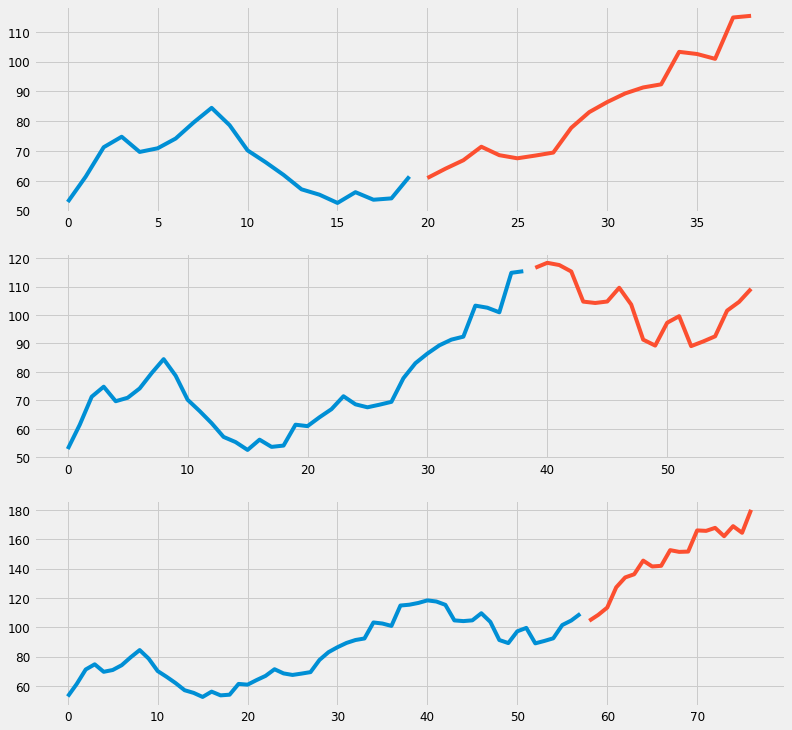

Train and Test different pairs across time series.

In [ ]:
train_list = {}
test_list = {}
time_series_splits = TimeSeriesSplit(n_splits=5)
X = modelling_series.values

index = 1
for train_index, test_index in time_series_splits.split(X):
    train = X[train_index]
    test = X[test_index]
    train_list[index] = train
    test_list[index] = test
    index += 1

In [ ]:
def backtest_model(train,test):
    model = sm.tsa.SARIMAX(train,order=(1,1,1),seasonal_order=(2,2,0,12))
    results=model.fit()


    # train_get_dates_beginning = '2012-01-31'
    # train_get_dates_ending = str(modelling_series.index[len(train)].date())
    # test_get_dates_beginning = train_get_dates_ending
    # test_get_dates_ending = str(modelling_series.index[len(train)+len(test)].date())


    # forecasts_train = results.predict(start=train_get_dates_beginning,end=train_get_dates_ending)
    # forecasts_test = results.predict(start=test_get_dates_beginning,end=test_get_dates_ending)

    forecasts_train = results.predict(start=0,end=len(train))
    forecasts_test = results.predict(start=len(train),end=len(train)+len(test))


    fig,(ax1,ax2) = plt.subplots(2,figsize=(18,10))

    train = pd.DataFrame(train)
    test = pd.DataFrame(test)

    forecasts_train = pd.DataFrame(forecasts_train)
    forecasts_test = pd.DataFrame(forecasts_test)

    forecasts_train.plot(label='Forecasts',ax=ax1,title='SARIMA Forecasting -Train Data')
    train.plot(label='Actual',ax=ax1)
    ax1.set_ylabel('Stock Price')
    ax1.set_xlabel('Time')


    forecasts_test.plot(label='Forecasts',ax=ax2,title='SARIMA Forecasting -Test Data')
    test.plot(label='Actual',ax=ax2)
    ax2.set_ylabel('Stock Price')
    ax2.set_xlabel('Time')


    
    

    ax1.legend()
    ax2.legend()
    plt.tight_layout(pad=2)

# Backtest Set 1

In [ ]:
## Backtest Set-1
backtest_model(train_list[2],test_list[2])

# Backtest Set-2


In [ ]:
## Backtest Set-3
backtest_model(train_list[4],test_list[4])

# Backtest Set-3

In [ ]:
## Backtest Set-4
backtest_model(train_list[5],test_list[5])

By using backtesting we can validate our model on multiple train-test splits.
Red is the training set and blue indicates test set.

# Forecasting Seasonal ARIMA

In [ ]:
model = sm.tsa.SARIMAX(train,order=(1,1,1),seasonal_order=(2,2,0,12))
results=model.fit()
forecasts_train = results.predict(start='2012-01-31',end='2016-09-30')
forecasts_test = results.predict(start='2016-10-31',end='2019-12-31')

In [ ]:
##Function to Calculate Result Metrics
def result_metrics(test_series,forecast_series,model_name):
  print('Result Metrics for {}'.format(model_name))
  print('R2 Score : ',round(r2_score(test_series,forecast_series),3))
  print('Mean Squared Error : ',round(mean_squared_error(test_series,forecast_series),3))
  print('Mean Absolute Error : ',round(mean_absolute_error(test_series,forecast_series),3))

In [ ]:
fig,(ax1,ax2) = plt.subplots(2,figsize=(18,10))

forecasts_train.plot(label='Forecasts',ax=ax1,title='SARIMA Forecasting -Train Data')
train.plot(label='Actual',ax=ax1)
ax1.set_ylabel('Stock Price')

forecasts_test.plot(label='Forecasts',ax=ax2,title='SARIMA Forecasting -Test Data')
test.plot(label='Actual',ax=ax2)
ax2.set_ylabel('Stock Price')

ax1.legend()
ax2.legend()
plt.tight_layout(pad=2)

In [ ]:
print(result_metrics(train,forecasts_train,'SARIMA-Train Data'))
print('----')
print(result_metrics(test,forecasts_test,'SARIMA-Test Data'))


Training and Test Accuracy is equivalent .
Model Fit is good , no overfit or underfit.

In [ ]:
print(results.summary())

In [ ]:
##Checking Model Diagnotics on Training Data
results.plot_diagnostics(figsize=(16, 16))
plt.show()

Inference from Residual Analysis :-

->We observe that the residual plot kind of follows stationarity.

->The Distribution of Training Data residuals is showing almost Normal Distribution.

->The QQPlot points towards Normal Distribution

->Correlogram shows no relation -which indicates they are un-correlated.

Overall the model is captured the Stock Price in a good manner.

# Residual Analysis Test Data




In [ ]:
residuals_test = test-forecasts_test

In [ ]:
fig,(ax1,ax2) = plt.subplots(2,figsize=(18,10))


residuals_test.plot(label='Residuals',ax=ax1,title='Stationarity Check Plot')
residuals_test.rolling(7).mean().plot(label='Rolling Mean',c='orange',ax=ax1)
residuals_test.rolling(7).std().plot(label='Rolling STD',c='yellow',ax=ax1)

qq_plot = qq(residuals_test,line='s',ax=ax2)
ax2.set_title('QQ Plot Residuals')
ax1.legend()
ax2.legend()
plt.tight_layout(pad=1)


In [ ]:
fig,(ax1,ax2) = plt.subplots(2,figsize=(18,10))

residuals_test.plot(kind='kde',ax=ax1,title='Distribution Residuals')

acf = plot_acf(residuals_test,ax=ax2,title='Autocorrelation Plot Residuals')

In [ ]:
residuals_test.describe()

In [ ]:
train_list = {}
test_list = {}
time_series_splits = TimeSeriesSplit(n_splits=4)
X = modelling_series.values

index = 1
for train_index, test_index in time_series_splits.split(X):
    train = X[train_index]
    test = X[test_index]
    train_list[index] = train
    test_list[index] = test
    index += 1

In [ ]:
modelling_series

In [ ]:
train_list[1]

In [ ]:
def backtest_model(train,test):
    model = sm.tsa.SARIMAX(train,order=(1,1,1),seasonal_order=(2,2,0,12))
    results=model.fit()


    # train_get_dates_beginning = '2012-01-31'
    # train_get_dates_ending = str(modelling_series.index[len(train)].date())
    # test_get_dates_beginning = train_get_dates_ending
    # test_get_dates_ending = str(modelling_series.index[len(train)+len(test)].date())


    # forecasts_train = results.predict(start=train_get_dates_beginning,end=train_get_dates_ending)
    # forecasts_test = results.predict(start=test_get_dates_beginning,end=test_get_dates_ending)

    forecasts_train = results.predict(start=0,end=len(train))
    forecasts_test = results.predict(start=len(train),end=len(train)+len(test))


    fig,(ax1,ax2) = plt.subplots(2,figsize=(18,10))

    train = pd.DataFrame(train)
    test = pd.DataFrame(test)

    forecasts_train = pd.DataFrame(forecasts_train)
    forecasts_test = pd.DataFrame(forecasts_test)

    forecasts_train.plot(label='Forecasts',ax=ax1,title='SARIMA Forecasting -Train Data')
    train.plot(label='Actual',ax=ax1)
    ax1.set_ylabel('Stock Price')

    forecasts_test.plot(label='Forecasts',ax=ax2,title='SARIMA Forecasting -Test Data')
    test.plot(label='Actual',ax=ax2)
    ax2.set_ylabel('Stock Price')

    ax1.legend()
    ax2.legend()
    plt.tight_layout(pad=2)

In [ ]:
## Backtest Set-1
backtest_model(train_list[1],test_list[1])

In [ ]:
backtest_model(train_list[2],test_list[2])

In [ ]:
backtest_model(train_list[3],test_list[3])

In [ ]:
forecasts_train

In [ ]:
fig,(ax1,ax2) = plt.subplots(2,figsize=(18,10))

forecasts_train.plot(label='Forecasts',ax=ax1,title='SARIMA Forecasting -Train Data')
train.plot(label='Actual',ax=ax1)
ax1.set_ylabel('Stock Price')

forecasts_test.plot(label='Forecasts',ax=ax2,title='SARIMA Forecasting -Test Data')
test.plot(label='Actual',ax=ax2)
ax2.set_ylabel('Stock Price')

ax1.legend()
ax2.legend()
plt.tight_layout(pad=2)

**Seasonal ARIMA-Verdict**

The mean value is close to zero but it suggests that there is some bias in the model.
Overall the model has performed good for a problem like Stock Price Prediction being a difficult problem .



# **Facebook's Prophet Model for Time Series**

In [ ]:
##Getting Data Ready for the Model
prophet_data = monthly_data
prophet_data['Date'] = prophet_data.index
prophet_data

In [ ]:
prophet_data.drop(labels=['Year','Month'],axis=1,inplace=True)

In [ ]:
prophet_data = prophet_data.reindex(columns=['Date','Adj Close'])

In [ ]:
##Prophet needs two columns in form of ds and y being Date and series
prophet_data.rename(columns={'Date':'ds',
                   'Adj Close':'y'},inplace=True)

In [ ]:
prophet_data

In [ ]:
##Spliting Train Test 
prophet_train,prophet_test = split(prophet_data,train_size=0.6,shuffle=False)
print('Training Data Size :',len(prophet_train))
print('Testing Data Size :',len(prophet_test))

In [ ]:
##Model Fitting Basic Model
prophet_model = Prophet(yearly_seasonality=True)
prophet_model.fit(prophet_train)

In [ ]:
future= prophet_model.make_future_dataframe(periods=39,freq='M')

In [ ]:
future

Forecasting Prophet-Basic Model

In [ ]:
##Predicting Using Prophet
forecast=prophet_model.predict(future)
forecast.index = prophet_data['y'].index


In [ ]:
prophet_df = pd.concat([forecast['yhat'],prophet_data['y']],axis=1,ignore_index=True)
prophet_df.columns = ['Predicted','Actual']
prophet_df

In [ ]:
fig = plt.figure(figsize=(12,10))
prophet_df['Predicted'][:57].plot(label='Predicted')
prophet_df['Actual'][:57].plot(label='Actual')
plt.title('Prophet Basic Model- Forecasting -Train Data')
plt.ylabel('Stock Price')
plt.legend()

In [ ]:
fig = plt.figure(figsize=(12,10))
prophet_df['Predicted'][57:].plot(label='Predicted')
prophet_df['Actual'][57:].plot(label='Actual')
plt.title('Prophet Basic Model- Forecasting -Test Data')
plt.ylabel('Stock Price')
plt.legend()

In [ ]:
print(result_metrics(prophet_df['Actual'][:57],prophet_df['Predicted'][:57],'Prophet Basic-Train Data'))

In [ ]:
print(result_metrics(prophet_df['Actual'][57:],prophet_df['Predicted'][57:],'Prophet Basic-Test Data'))

The Basic Prophet Model with default parameters overfits into the model as represented by the Train Test Accuracy differences.

In [ ]:
fig = prophet_model.plot_components(forecast)

In [ ]:
print('Head',prophet_test.head(1))
print('Tail',prophet_test.tail(1))

Seasonal-ARIMA seems to have captured the model in a better way.


**Hyper-Tuning for Prophet Model**

In [ ]:
from sklearn.model_selection import ParameterGrid
params_grid = {'seasonality_mode':('multiplicative','additive'),
               'changepoint_prior_scale':[0.3,0.4],
              'holidays_prior_scale':[0.3,0.4],
              'n_changepoints' : [20,50]}
grid = ParameterGrid(params_grid)
cnt = 0
for p in grid:
    cnt = cnt+1

print('Total Possible Models',cnt)

In [ ]:
df = prophet_data 

In [ ]:
prophet_train_hyper,prophet_test_hyper = split(prophet_data,train_size=0.7,shuffle=False)

In [ ]:
prophet_test_hyper.head(5)

In [ ]:
len(prophet_test_hyper)

In [ ]:
strt='2017-08-31'
end='2019-12-31'
model_parameters = pd.DataFrame(columns = ['MAPE','Parameters'])
for i in grid:
    test = pd.DataFrame()
    print(i)
    
    train_model =Prophet(changepoint_prior_scale = i['changepoint_prior_scale'],
                         holidays_prior_scale = i['holidays_prior_scale'],
                         n_changepoints = i['n_changepoints'],
                         seasonality_mode = i['seasonality_mode'],
                         weekly_seasonality=False,
                         daily_seasonality = False,
                         yearly_seasonality = True,
                         )
    
    train_model.fit(prophet_train_hyper)
    train_forecast = train_model.make_future_dataframe(periods=29, freq='M',include_history = False)
    train_forecast = train_model.predict(train_forecast)
    test=train_forecast[['ds','yhat']]
    Actual = df[(df['ds']>=strt) & (df['ds']<=end)]
    MAPE = mean_absolute_percentage_error(Actual['y'],abs(test['yhat']))
    print('Mean Absolute Percentage Error(MAPE)---------------------------------------------------------',MAPE)
    model_parameters = model_parameters.append({'MAPE':MAPE,'Parameters':p},ignore_index=True)

In [ ]:
parameters = model_parameters.sort_values(by=['MAPE'])
parameters = parameters.reset_index(drop=True)
parameters.head(3)

In [ ]:
parameters['Parameters'][0]

Problem with Prophet is its Overfits quite easily for out dataset.
Therefore we try some other hyperparamters with Hit and Trial

In [ ]:
prophet_tuned_model = Prophet(
                      growth='linear',
                      changepoint_prior_scale= 0.001,
                      holidays_prior_scale = 0.02,
                      seasonality_prior_scale=0.3,
                      
                      seasonality_mode = 'additive',
                      weekly_seasonality=False,
                      daily_seasonality = False,
                      yearly_seasonality = True,
                      changepoints=['2017-07-31']
                      )
prophet_tuned_model.add_country_holidays(country_name='US')
prophet_tuned_model.add_seasonality(name='monthly', period=30.5, fourier_order=5, prior_scale=0.02)
prophet_tuned_model.add_seasonality(name='yearly', period=365, fourier_order=20)
prophet_tuned_model.add_country_holidays(country_name='US')
prophet_tuned_model.fit(prophet_train_hyper)

In [ ]:
future_hyper= prophet_tuned_model.make_future_dataframe(periods=29,freq='M')

In [ ]:
future_hyper=prophet_tuned_model.predict(future_hyper)

In [ ]:
future_hyper.index = prophet_data['y'].index

In [ ]:
prophet_hyper_df = pd.concat([future_hyper['yhat'],prophet_data['y']],axis=1,ignore_index=True)

In [ ]:
prophet_hyper_df.columns = ['Predicted','Actual']
prophet_hyper_df.tail(3)

In [ ]:
fig = plt.figure(figsize=(12,10))
prophet_hyper_df['Predicted'][:57].plot(label='Predicted')
prophet_hyper_df['Actual'][:57].plot(label='Actual')
plt.title('Prophet Hyper Param Tuned- Forecasting -Train Data')
plt.ylabel('Stock Price')
plt.legend()

In [ ]:
fig = plt.figure(figsize=(12,10))
prophet_hyper_df['Predicted'][57:].plot(label='Predicted')
prophet_hyper_df['Actual'][57:].plot(label='Actual')
plt.title('Prophet Hyper Param Tuned- Forecasting -Test Data')
plt.ylabel('Stock Price')
plt.legend()

In [ ]:
result_metrics(prophet_hyper_df['Actual'][:67],prophet_hyper_df['Predicted'][:67],'Hyper-Tuned Prophet Train Data')

In [ ]:
result_metrics(prophet_hyper_df['Actual'][67:],prophet_hyper_df['Predicted'][67:],'Hyper-Tuned Prophet Test Data')

After Hyper-parameter tuning the model is not able to capture the seasonality and sudden jump in time series in the Year 2017 onwards.

->Prophet is easily overfitted.

->Seasonal ARIMA is superior to Prophet

->Prophet is good at capturing the trend.

->By creating Extra Regressors we can maybe improve the Results in future projects.




**Project Summary**

Seasonal ARIMA Vs Facebook's Prophet

->Advantages of Prophet includes very easy to implement, fast , and less statistical know-how model . In Seasonal ARIMA we had to follow lot of tests and process to generate predictions.

->Seasonal ARIMA is better at capturing the seasonality part .

->Prophet has a overfitting problem .

->Overall Both models are robust .

->Prophet is better at dealing with outliers.

->We have found Seasonal ARIMA is much better our at prediction problem.
More confidence when predicting with Seasonal-ARIMA since its backed by Mathematical and Statistical tests.

->Accuracy of SARIMA is 89% and 80% for Prophet(Both on Out of Sample Data)




# Actionable Insight 
Observing the Trend given by Both Models.

**AAPL IS A BUY.**